# Check 35-00103 counties

From the sanity check for department 35-00103 (Charlotte, NC), it seems that we are retrieving data from some counties that are far away. Let's see why so.

In [12]:
import us

from cpe_help import Department
from cpe_help.tiger import get_tiger

%matplotlib inline

In [13]:
dept = Department('35-00103')
tiger = get_tiger()

In [62]:
city = dept.load_city_metadata()
tracts = dept.load_census_tracts()
precincts = dept.load_police_precincts()

In [63]:
area = precincts.unary_union.union(city.geometry.iloc[0])

_counties = tiger.load_county_boundaries()
counties = _counties[_counties.intersects(area)]

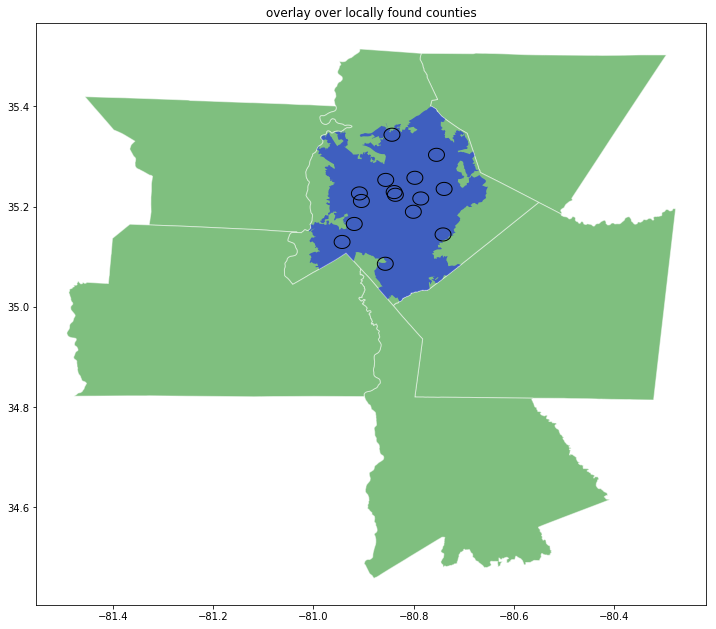

In [67]:
ax = counties.plot(color='green', edgecolor='white', alpha=0.5, figsize=(12, 12))
city.plot(ax=ax, color='blue', alpha=0.5)
precincts.plot(ax=ax, color='none', edgecolor='black')
ax.set_title('overlay over locally found counties');

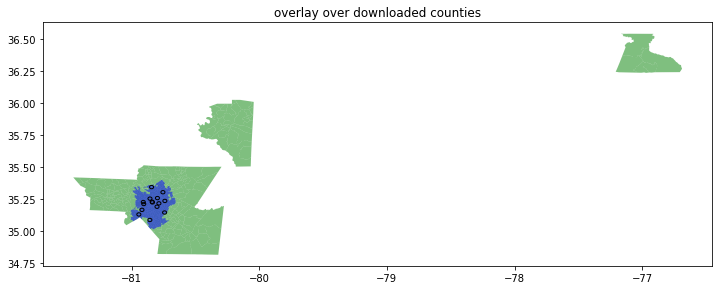

In [66]:
ax = tracts.plot(color='green', alpha=0.5, figsize=(12, 12))
city.plot(ax=ax, color='blue', alpha=0.5)
precincts.plot(ax=ax, color='none', edgecolor='black')
ax.set_title('overlay over downloaded counties');

Found it! The problem is the following:

Before attempting anything, there have been coordinate transformations on the shapes. Also, there's a bit of error from data collecting, anyway... There's a bit of error (not visible with the raw eye).

Charlotte is a special case because it sits on the boundary between North Carolina and South Carolina.

This causes a problem where some counties located in South Carolina are identified as needed by the algorithm. We save their numbers and later, when we are up to retrieve them, the machine actually make a request to North Carolina, using the county number from the south.

This results in unexpected counties being retrieved (and possibly a error if not found).

The areal interpolation interpolation itself has a tolerance, so we don't see the flutters here noticed by the algorithm (usually, it will raise an error if there's a missing part of the target polygons).

Now that I think of it, the usage of buffers around points might lead to a similar problem, but in this case, the areal interpolation may fail (as the contact with the other state is bigger).

To solve this, we can set up a tolerance in the `guess_counties` function (others as well?). Also, the usage of unconstrained buffer points should be avoided by CPE (I can leave this only as an example though... Voronoi diagrams would perform better).

In [56]:
us.states.lookup('37')

<State:North Carolina>

In [55]:
us.states.lookup('45')

<State:South Carolina>

In [68]:
counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
577,37,025,01008540,37025,Cabarrus,Cabarrus County,06,H1,G4020,172,16740,None,A,935603281,7006691,+35.3883690,-080.5526938,"POLYGON ((-80.76429499999999 35.400203, -80.76..."
1941,37,071,01008554,37071,Gaston,Gaston County,06,H1,G4020,172,16740,None,A,921966686,21053460,+35.2933443,-081.1772556,"POLYGON ((-81.364925 35.311225, -81.3661209999..."
2094,37,179,01008590,37179,Union,Union County,06,H1,G4020,172,16740,None,A,1636095292,20333224,+34.9918171,-080.5304354,"POLYGON ((-80.62830199999999 35.145725, -80.62..."
2266,37,119,01008570,37119,Mecklenburg,Mecklenburg County,06,H1,G4020,172,16740,None,A,1356116196,56318899,+35.2468623,-080.8338317,"POLYGON ((-80.87437299999999 35.512524, -80.86..."
2338,45,057,01248008,45057,Lancaster,Lancaster County,06,H1,G4020,172,16740,None,A,1422314508,15444741,+34.6868182,-080.7036885,"POLYGON ((-80.87579699999999 34.785246, -80.87..."
3039,45,091,01248019,45091,York,York County,06,H1,G4020,172,16740,None,A,1762994167,39140861,+34.9701875,-081.1831873,"POLYGON ((-81.40714799999999 35.072473, -81.40..."
